<a href="https://colab.research.google.com/github/brucker3/CS5560_proejct/blob/main/KDM_spanish_v2_merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Summarization**

# Importing needed libraries for preprocessing and model building

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
import io
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
nltk.download('punkt') # one time execution
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
!pip install googletrans==3.1.0a0
from googletrans import Translator, constants
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import average_precision_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 1.0MB 13.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=8dfcf4bb70a05254cd1985b8f049711106adf38e9ef1c960887ee5c6fa0decca
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans


In [3]:
#import of standford data set 
# this code was seperated from the main import block because it takes so long to run 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-05-04 02:12:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-04 02:12:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-04 02:12:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# Reading and viewing the dataset

In [4]:
# this mehtod of reading in text works better for full text files 
# other method to read in articles 
txt = "/content/SpanishArticle.txt"

# opening and converting read in files to use able form 
txt = open(txt, "r")
text_sring_difLan = txt.read()
print(type(text_sring_difLan))
print(text_sring_difLan)
txt.close()


#Translate string into english
translator = Translator() #Google API translator
#Translates automatically from spanish to english, to translate differentlanguage, 
#translator.translate("Phrase", dest = "language code")
english = translator.translate(text_sring_difLan, dest = "en")
text_sring=english.text

<class 'str'>
Londres (CNN)– El organismo de control del gasto político de Gran Bretaña iniciará una investigación formal sobre la financiación de las renovaciones del departamento del primer ministro Boris Johnson en Downing Street, dado que se enfrenta a múltiples acusaciones de corrupción y escándalo político. La Comisión Electoral del Reino Unido dijo en un comunicado este miércoles que «hay motivos razonables para sospechar que puede haber un delito o delitos. Por lo tanto, continuaremos este trabajo como una investigación formal para establecer si este es el caso». Johnson ha sido presionado para que explique cómo pagó las remodelaciones de su departamento, que según los medios de comunicación británicos costaron alrededor de £ 200,000 (US$ 280,000). Los primeros ministros reciben £ 30,000 (US$ 41,000) de dinero público al año para renovar la propiedad durante su mandato. El líder del Reino Unido se enfrentó a un mayor escrutinio después de que su ex asesor principal lanzara acus

# Cleaning and Preprocessing

In [7]:
#remove stopwords from the sentences
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

# build word dictionary 
def dic_builder(file, dic ):
  for line in glo_file:
      line = line.split()
      values  = np.array(line[1:], dtype='float32')
      dic[line[0]] = values
  return dic 

# turn sentences into vecotrs 
def sen_vec(sentences, word_embeddings):
  vectors = []
  vec = 0 
  for i in sentences:
    if len(i) == 0:
      vec = np.zeros((200,))
    elif len(i) != 0:
      for word in i.split():
        vec = sum([word_embeddings.get(word, np.zeros((200,)))])/(len(i.split())+0.001)
    vectors.append(vec)
  return vectors 


def sentence_ranker(sentences, sentence_vectors, graph_out = False):
  sim_matrix = np.zeros([len(sentences), len(sentences)])
  for index_1 in range(len(sentences)):
    for index_2 in range(len(sentences)):
      if index_1 != index_2:
        sim_matrix[index_1][index_2] = cosine_similarity(sentence_vectors[index_1].reshape(1,200), sentence_vectors[index_2].reshape(1,200))[0,0]
  # converting scores to graph
  graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(graph) 
  if graph_out == False:
    return sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True) 
  elif graph_out == True: 
    return graph

# build dictionary fo words vectors 
word_embeddings = {}
glo_file = open('glove.6B.200d.txt', encoding='utf-8')
word_embeddings = dic_builder(glo_file, word_embeddings)
glo_file.close()

# sentence clean up 
# remove punctuations, numbers and special characters.
sentences = text_sring.split('.') 
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
print(clean_sentences)

# sentence vectrorization 
sentence_vectors = sen_vec(clean_sentences,word_embeddings)

# ranking sentence with page rank 
ranked_sentences = sentence_ranker(sentences, sentence_vectors)
graph = sentence_ranker(sentences, sentence_vectors, graph_out = True)

['london cnn britain political spending watchdog launch formal investigation funding renovations prime minister boris johnson downing street apartment faces multiple allegations corruption political scandal', 'uk election commission said statement wednesday reasonable grounds suspect may crime crimes', 'therefore continue work formal investigation establish whether case', 'johnson pressured explain paid renovations apartment according british media cost around us', 'prime ministers receive us public money year renovate property tenure', 'uk leader faced increased scrutiny former senior adviser launched allegations unethical behavior last week', 'dominic cummings stepped role johnson former senior adviser late last year earning reputation advocate brexit policy prime minister election said blog post johnson planned make conservative party donors pay renewal', 'case loan would declared electoral commission', 'political grants loans strictly controlled uk loans us recorded publicly disclo

In [8]:
# output 
clound_sentences = " "  
cosSim=[]
print("the total number of sentences is", len(sentences))
print("the total number of sentences is", len(ranked_sentences))

# Extract top 5 sentences for word cloud
for i in range(0,5):
  print("--------------")
  print("ranked senctence number", i)
  print(ranked_sentences[i][0])
  print("cosine score" , ranked_sentences[i])
  clound_sentences += ranked_sentences[i][1]

#Extract cosine score for all sentences for graphical purposes:
for i in range(len(ranked_sentences)):
  cosSim.append(ranked_sentences[i][0])

the total number of sentences is 43
the total number of sentences is 43
--------------
ranked senctence number 0
0.04147441572023797
cosine score (0.04147441572023797, ' The UK leader faced increased scrutiny after his former senior adviser launched allegations of unethical behavior last week')
--------------
ranked senctence number 1
0.04147441276029083
cosine score (0.04147441276029083, '" Johnson again denied that he made any such comments, despite multiple media reports citing anonymous sources this week')
--------------
ranked senctence number 2
0.03854705072855534
cosine score (0.03854705072855534, ' Therefore, we will continue this work as a formal investigation to establish whether this is the case')
--------------
ranked senctence number 3
0.03758767092070329
cosine score (0.03758767092070329, '" CNN contacted the prime minister\'s office for his opinion on Wednesday')
--------------
ranked senctence number 4
0.03731347782826531
cosine score (0.03731347782826531, ' Political g

(-0.5, 399.5, 199.5, -0.5)

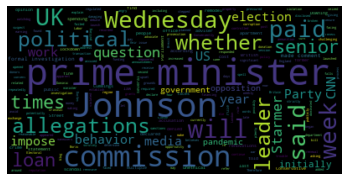

In [9]:
# word clounds for original text English
wordCloud = WordCloud().generate(text_sring)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

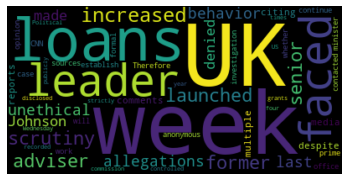

In [10]:
# clound for ranked sentences English
wordCloud = WordCloud().generate(clound_sentences)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

In [11]:
translation = translator.translate(clound_sentences, dest = "es") #Change the last portion to the language the article originated from
print(f"{translation.origin} ({translation.src}) --> {translation.text}({translation.dest})")

  The UK leader faced increased scrutiny after his former senior adviser launched allegations of unethical behavior last week" Johnson again denied that he made any such comments, despite multiple media reports citing anonymous sources this week Therefore, we will continue this work as a formal investigation to establish whether this is the case" CNN contacted the prime minister's office for his opinion on Wednesday Political grants and loans are strictly controlled in the UK, and loans of more than £ 7,500 (US $ 10,400) are recorded and publicly disclosed by the commission four times a year (en) --> El líder del Reino Unido se enfrentó a un mayor escrutinio después de que su ex asesor principal lanzara acusaciones de comportamiento poco ético la semana pasada "Johnson volvió a negar que hizo tales comentarios, a pesar de múltiples informes de los medios que citan fuentes anónimas esta semana. Por lo tanto, continuaremos este trabajo como una investigación formal para establecer si est

(-0.5, 399.5, 199.5, -0.5)

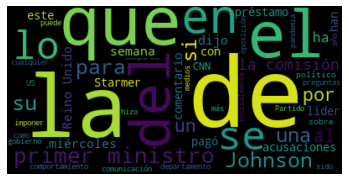

In [12]:
# word clounds for original text Different Language
wordCloud = WordCloud().generate(text_sring_difLan)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

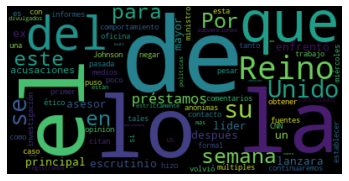

In [13]:
# clound for ranked sentences Different Language
wordCloud = WordCloud().generate(translation.text)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

Text(0.5, 1.0, 'Cosine Similarity of All Sentences')

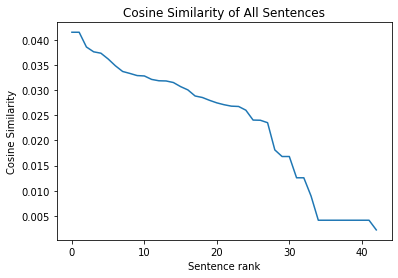

In [14]:
plt.plot(cosSim)
plt.xlabel("Sentence rank")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of All Sentences")

cosin 
[0.04147441572023797, 0.04147441276029083, 0.03854705072855534, 0.03758767092070329, 0.03731347782826531, 0.03616447273662152, 0.03481323982925384, 0.03368418660057291, 0.033294593191543, 0.03287030340369525, 0.03279272969061829, 0.0321076650953662, 0.03183829080845428, 0.03179932726851384, 0.03149065053834973, 0.03067570124113397, 0.03002614519930283, 0.028815851067696054, 0.028516778348407698, 0.027949312005678576, 0.027449622025872273, 0.027080610296640016, 0.026797675151453332, 0.02673494578773427, 0.025998007687425946, 0.02403452696719034, 0.023998328791278556, 0.023512297906704116, 0.018106459458941255, 0.0167971329160856, 0.016797132599399193, 0.012572217600483255, 0.01257221707733925, 0.008943487931347499, 0.00414364643840322, 0.00414364643840322, 0.00414364643840322, 0.00414364643840322, 0.00414364643840322, 0.00414364643840322, 0.00414364643840322, 0.00414364643840322, 0.0022198913116185832]
-------
average percision when 0 are entered as ture response nan
average perc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning:

invalid value encountered in true_divide



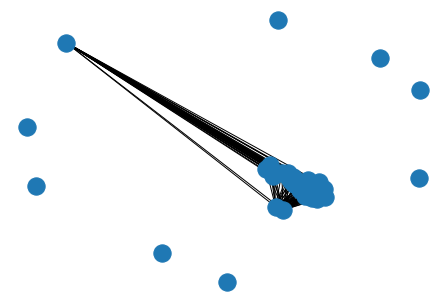

In [15]:
print("cosin ")
print(cosSim)
true_socres  = np.zeros([len(cosSim)])
true_socres_1  = np.ones([len(cosSim)])
print("-------")
# average percision aganist cosine scores 
# average percsiion was not original built
average_percision_cosine_1 = average_precision_score(true_socres_1, cosSim)
average_percision__cosine_0 = average_precision_score(true_socres, cosSim)
print("average percision when 0 are entered as ture response", average_percision__cosine_0)
print("average percision when 1 are entered as ture response", average_percision_cosine_1)
print("-------")
print("graphy of simularity scores beore applying page rank ")
nx.draw(graph)
#A cosine value of 0 means that the two vectors are at 90 degrees 
#to each other (orthogonal) and have no match. The closer the cosine 
#value to 1, the smaller the angle and the greater the match between vectors.

# Topic Modeling 

In [1]:
#installing pyLDAvis and gensim
!pip install -U pyLDAvis
!pip install -U gensim

Requirement already up-to-date: pyLDAvis in /usr/local/lib/python3.7/dist-packages (3.3.1)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [2]:
#importing Libraries needed for completion of topic modeling
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import numpy as np
import time
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecate

In [3]:
#read the text file 
# with open('/content/SpanishArticle.txt', 'r') as f:
#     text = f.readlines()
with open('./SpanishArticle.txt', 'r') as f:
    meta = f.readlines()

text = meta[0].split('.')
file_df = pd.DataFrame(text, columns=['text'])
# reviews_df=pd.read_csv('/content/SpanishArticle.txt',error_bad_lines=False)
print(file_df.head(6))
print("----------")
print(file_df.dtypes)
print("----------")
print(file_df.shape)


                                                text
0  Londres (CNN)– El organismo de control del gas...
1   La Comisión Electoral del Reino Unido dijo en...
2   Por lo tanto, continuaremos este trabajo como...
3   Johnson ha sido presionado para que explique ...
4   Los primeros ministros reciben £ 30,000 (US$ ...
5   El líder del Reino Unido se enfrentó a un may...
----------
text    object
dtype: object
----------
(32, 1)


# Text Cleaning and Preprocessing

In [4]:
def initial_clean(text):
    """
    Function to clean text-remove punctuations, lowercase text etc.
    """
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower()  # lower case text
    text = nltk.word_tokenize(text)
    return (text)

## Identifying and removing stopwords

In [5]:
stop_words = stopwords.words('english')
# adding some more stop words that doesn't convey much meaning in terms of reviews feel free to extend or reduce this list
stop_words.extend(['news', 'say','use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do','took','time','year',
                 'done', 'try', 'many', 'some','nice', 'thank', 'think', 'see', 'rather',
                  'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 
                   'even', 'right', 'line','even', 'also', 'may', 'take', 'come',
                   'new','said', 'like','people'])

In [6]:
def remove_stop_words(text):
     return [word for word in text if word not in stop_words]

# Stemming

In [7]:
stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # no single letter words
    except IndexError:
        pass

    return text

# Applying all functions into one

In [8]:
def apply_all(text):
    """
    
    """
    return stem_words(remove_stop_words(initial_clean(text)))

print(apply_all)

<function apply_all at 0x7f3325a63170>


# Tokenization

In [9]:
t1 = time.time()
file_df['tokenized_text'] = file_df['text'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(file_df), "SpanishArticle:", (t2-t1)/60, "min") #Time to clean and tokenize 3209 reviews: 0.21254388093948365 min

print('\n')
print("text with their respective tokenize version:" )
print(file_df.head(5))

Time to clean and tokenize 32 SpanishArticle: 0.0005333304405212402 min


text with their respective tokenize version:
                                                text                                     tokenized_text
0  Londres (CNN)– El organismo de control del gas...  [londr, cnn, el, organismo, de, control, del, ...
1   La Comisión Electoral del Reino Unido dijo en...  [la, comisin, elector, del, reino, unido, dijo...
2   Por lo tanto, continuaremos este trabajo como...  [por, lo, tanto, continuaremo, est, trabajo, c...
3   Johnson ha sido presionado para que explique ...  [johnson, ha, sido, presionado, para, que, exp...
4   Los primeros ministros reciben £ 30,000 (US$ ...  [lo, primero, ministro, reciben, us, de, diner...


# LDA implementation

In [10]:

#Creating a Gensim dictionary from the tokenized data
tokenized = file_df['tokenized_text']
#Creating term dictionary of corpus, where each unique term is assigned an index.
dictionary = corpora.Dictionary(tokenized)
#Filtering terms .
dictionary.filter_extremes(no_below=1, no_above=0.8)
#converting the dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized]
print(corpus[:1])

print([[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]
[[('acusacion', 1), ('bori', 1), ('bretaa', 1), ('cnn', 1), ('control', 1), ('corrupcin', 1), ('dado', 1), ('de', 4), ('del', 3), ('departamento', 1), ('down', 1), ('el', 1), ('en', 1), ('enfrenta', 1), ('escndalo', 1), ('financiacin', 1), ('formal', 1), ('gasto', 1), ('gran', 1), ('iniciar', 1), ('investigacin', 1), ('johnson', 1), ('londr', 1), ('ministro', 1), ('mltipl', 1), ('organismo', 1), ('poltico', 2), ('primer', 1), ('que', 1), ('renovacion', 1), ('se', 1), ('sobr', 1), ('street', 1), ('una', 1)]]


In [11]:
#choosing hyperparameter values; num_topics=10, alpha=0.05, eta=0.61, num_words=5 
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=7, alpha=0.05, eta=0.61)

#saving the model
ldamodel.save('model_combined.gensim')
topics = ldamodel.print_topics(num_words=5)
print('\n')
print("Now printing the topics and their composition")
print("This output shows the Topic-Words matrix for the 10 topics created and the 5 words within each topic")
for topic in topics:
   print(topic)



Now printing the topics and their composition
This output shows the Topic-Words matrix for the 10 topics created and the 5 words within each topic
(0, '0.010*"que" + 0.010*"de" + 0.010*"un" + 0.010*"en" + 0.010*"lo"')
(1, '0.003*"de" + 0.003*"ex" + 0.003*"su" + 0.003*"que" + 0.003*"princip"')
(2, '0.013*"de" + 0.010*"ministro" + 0.010*"al" + 0.010*"comentario" + 0.006*"el"')
(3, '0.054*"de" + 0.032*"que" + 0.023*"el" + 0.021*"del" + 0.016*"ministro"')
(4, '0.007*"fiscala" + 0.007*"del" + 0.007*"pued" + 0.007*"aparent" + 0.007*"cualquier"')
(5, '0.014*"est" + 0.010*"para" + 0.006*"pedirl" + 0.006*"primer" + 0.006*"cnn"')
(6, '0.027*"el" + 0.013*"su" + 0.009*"de" + 0.009*"primer" + 0.009*"ministro"')
(7, '0.028*"de" + 0.020*"el" + 0.014*"para" + 0.014*"en" + 0.011*"semana"')
(8, '0.026*"que" + 0.017*"de" + 0.014*"lo" + 0.014*"en" + 0.014*"se"')
(9, '0.003*"hizo" + 0.003*"pero" + 0.003*"cuestin" + 0.003*"diciendo" + 0.003*"tema"')


In [12]:
# Compute Coherence Score for num_topics=10, alpha=0.05, eta=0.61, num_words=5
coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.33746140972712363


In [13]:
#visualizing topics for alpha=0.05, eta=0.61
lda_viz = gensim.models.ldamodel.LdaModel.load('/content/model_combined.gensim')
lda_display = pyLDAvis.gensim_models.prepare(lda_viz, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)